In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.integrate import quad
import pandas as pd
from statistics import mean, median, mode
from matplotlib.animation import FuncAnimation
#%matplotlib widget

In [2]:
SolarMass = 1.98*10**30
pc = 3.086*10**16
kpc = 1000*pc
G = 6.67430*10**(-11)

In [3]:
#Data
r_vals_UGC05721 = [0.09, 0.27, 0.45, 0.63, 0.81, 0.99, 1.17, 1.35, 1.53, 1.71, 1.89, \
2.07, 2.25, 2.67, 3.15, 3.61, 4.04, 4.49, 4.93, 5.38, 5.86, 6.28, 6.74]
obs = [16.5, 38.5, 47.4, 55.5, 56.4, 59.8, 67.8, 76.4, 81.2, 82.2, 82.6, \
82.3, 82.1, 81.4, 79.3, 78.5, 78.2, 78.1, 78.2, 78.3, 78.6, 78.9, 79.5]
noise = [4.57, 6.88, 4.57, 4.57, 5.45, 4.57, 4.57, 4.57, 4.57, 19.2, 4.57, \
4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57]
disk = [16.63, 32.22, 40.27, 43.48, 44.07, 43.71, 44.14, 42.83, 40.98, 38.82, \
36.95, 35.17, 33.75, 30.81, 27.99, 25.88, 24.31, 22.96, 21.83, 20.85, \
19.94, 19.24, 18.55]
gas = [1.23, 3.67, 5.99, 8.14, 10.08, 11.72, 13.25, 15.37, 18.44, 21.32, \
22.09, 20.36, 17.96, 18.44, 20.36, 20.55, 20.74, 21.71, 23.34, 24.59, \
24.78, 24.59, 24.59]

data = []
for i in range(len(obs)):
    data.append([r_vals_UGC05721[i], obs[i], noise[i], disk[i], gas[i]])

data = np.array(data)

datadf = pd.DataFrame(data, columns=['radius', 'velocity', 'error', 'disk', 'gas'])

x = datadf['radius']
y = datadf['velocity']
err = datadf['error']

In [4]:
#define model
def fdm_density(a, b, r1):
    rc = 0.824298*(b/(10**4))*(10**(-22)/a) #kpc
    return 0.019*((a/10**(-22))**(-2))*(rc**(-4))/(1 + 0.091*(r1/rc)**2)**8 #SolarMass/pc^3

def nfw_density(p, q, r2):
    return p/((r2/q)*(1 + (r2/q))**2)

def model(params):
    mass, scale, rtrans, rscale, upsilon = params
    rho0 = (4.11544*10**58*mass**2*rtrans*(1. + rtrans/rscale)**2)/(rscale*(1. + (1.33928*10**51*mass**2*rtrans**2)/scale**2)**8*scale**4)

    vel_th = []
    
    for j in range(len(data)):
        rad = data[j][0]
        integrand = lambda r: (np.heaviside(rtrans - r, 1)*fdm_density(mass, scale, r) + \
        np.heaviside(r - rtrans, 0)*nfw_density(rho0, rscale, r))*(r**2)*(SolarMass)/(pc**3)*(kpc**3)
        integral = quad(integrand, 1e-3, rad)[0]
        vel = np.sqrt(4*np.pi*G*integral/(rad*kpc))/1000
        #vel_th.append([data[j][0], np.sqrt(vel**2 + upsilon*data[j][3]**2 + np.abs(data[j][4])*data[j][4])])
        vel_th.append(np.sqrt(vel**2 + upsilon*data[j][3]**2 + np.abs(data[j][4])*data[j][4]))

    #vel_th = pd.DataFrame(vel_th, columns=["radius", "velocity"])
    vel_th = np.array(vel_th)
    return vel_th

In [5]:
model([1e-22, 5000, 3, 10, 0.5])

array([15.28064372, 35.36310593, 48.26569074, 54.58921994, 56.35280776,
       55.74203375, 54.65609407, 52.93155911, 51.54225168, 50.38280941,
       48.76359245, 46.22485944, 43.68227086, 40.88090254, 39.14551554,
       37.29368556, 35.94235935, 35.27609938, 35.31405284, 35.31702723,
       34.68868868, 33.97234175, 33.4101353 ])

In [6]:
# Define the target distribution (e.g., Normal likelihood)
def log_likelihood(params,x,y,err):
    
    return -0.5 * np.sum(((y - model(params)) / err) ** 2)  # chi^2 likelihood

In [7]:
# Define the prior (assuming Gaussian priors on mu and sigma)
def log_prior(params):
    mass, scale, rtrans, rscale, upsilon = params
    if (1e-24 <= mass <= 1e-21 and 500 <= scale <= 15000 and 1 <= rtrans <= np.max(data[:,0]) and 1 <= rscale <= 25 and 0.1 <= upsilon <= 1):  # sigma must be positive
        return 0
    else:
        return -np.inf

In [8]:
# Define the posterior as a combination of likelihood and prior
def log_posterior(x,y,err,params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(params,x,y,err) + log_prior(params)

In [9]:
#defining the proposal distribution, here proposal distribution is gaussian / normal
def proposal_density(current_params,proposal_params):
            current_mass,current_scale,current_rtrans,current_rscale,current_upsilon = current_params
            proposal_width_mass,proposal_width_scale,proposal_width_rtrans,proposal_width_rscale,proposal_width_upsilon = proposal_params

            
            proposed_mass = np.random.normal(current_mass, proposal_width_mass)
            proposed_scale = np.random.normal(current_scale, proposal_width_scale)
            proposed_rtrans = np.random.normal(current_rtrans, proposal_width_rtrans)
            proposed_rscale = np.random.normal(current_rscale, proposal_width_rscale)
            proposed_upsilon = np.random.normal(current_upsilon, proposal_width_upsilon)

            
            return proposed_mass,proposed_scale,proposed_rtrans,proposed_rscale,proposed_upsilon

In [10]:
# Metropolis-Algorithm MCMC

def metropolis_hastings(x,y,err,initial_params,proposal_params,n_iters):
    # Initial values
    current_mass,current_scale,current_rtrans,current_rscale,current_upsilon = initial_params
    trace_params = [[current_mass],[current_scale],[current_rtrans],[current_rscale],[current_upsilon]]
    

    for i in range(n_iters):

        # Propose new values from current_values based on the proposal density
        current_params = current_mass,current_scale,current_rtrans,current_rscale,current_upsilon
        proposed_params = proposal_density(current_params,proposal_params)

        # Calculate log-posterior for current and proposed values
        current_log_posterior = log_posterior(x,y,err, current_params)
        proposed_log_posterior = log_posterior(x,y,err, proposed_params)

        # Acceptance ratio
        acceptance_ratio = np.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the new state
        u = np.random.rand()
        if u < acceptance_ratio:
            current_mass = proposed_params[0]
            current_scale = proposed_params[1]
            current_rtrans = proposed_params[2]
            current_rscale = proposed_params[3]
            current_upsilon = proposed_params[4]

        # Append the current values to the trace
        trace_params[0].append(current_mass)
        trace_params[1].append(current_scale)
        trace_params[2].append(current_rtrans)
        trace_params[3].append(current_rscale)
        trace_params[4].append(current_upsilon)

    return np.array(trace_params)

In [11]:
# print(np.random.uniform(low=[1e-23, 1500, 1, 1, 0.3], high=[1e-22, 5000, np.max(data[:,0])+1, 15, 0.8], size=(1, ndim)).flatten())

In [12]:
# Run MCMC
ndim = 5
n_iters = 1000000
initial_params = np.random.uniform(low=[1e-23, 1500, 1, 1, 0.3], high=[1e-22, 5000, np.max(data[:,0])+1, 15, 0.8], size=(1, ndim)).flatten()
proposal_params = 0.05e-23,50,0.05,0.5,0.01 #proposal width

#MCMC start
trace_params = metropolis_hastings(x,y,err,initial_params,proposal_params,n_iters)

In [ ]:
#trace_params[0][1000:]

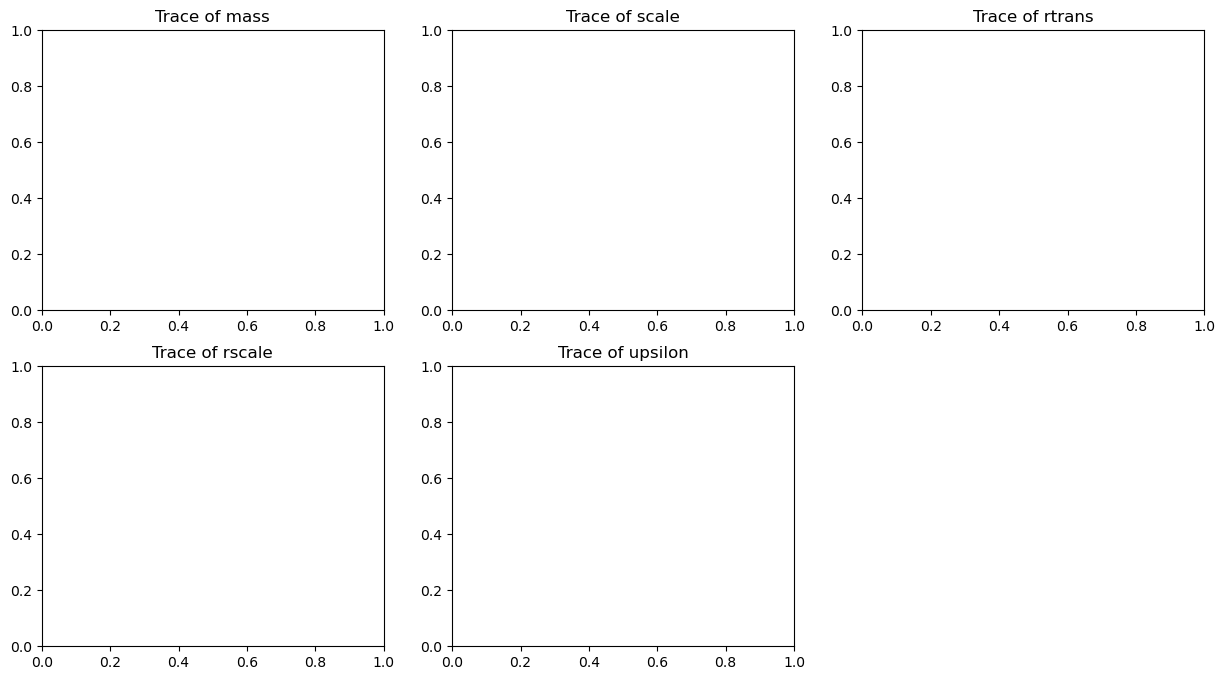

In [14]:
# Animation setup
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes[0,0].set_title("Trace of mass")
axes[0,1].set_title("Trace of scale")
axes[0,2].set_title("Trace of rtrans")
axes[1,0].set_title("Trace of rscale")
axes[1,1].set_title("Trace of upsilon")
fig.delaxes(axes[1, 2])

bin_mass = np.linspace(1e-24,1e-21)
bin_scale = np.linspace(500,15000)
bin_rtrans = np.linspace(1,np.max(data[:,0]))
bin_rscale = np.linspace(1,25)
bin_upsilon = np.linspace(0.1,1)

def update(frame):
    axes[0,0].cla()
    axes[0,1].cla()
    axes[0,2].cla()
    axes[1,0].cla()
    axes[1,1].cla()

    axes[0,0].hist(trace_params[0, :frame], bins=bin_mass, color='blue', alpha=0.7)
    axes[0,0].set_title(f"Trace of mass (iteration : {frame})")
    axes[0,1].hist(trace_params[1, :frame], bins=bin_scale, color='red', alpha=0.7)
    axes[0,1].set_title(f"Trace of scale (iteration : {frame})")
    axes[0,2].hist(trace_params[2, :frame], bins=bin_rtrans, color='green', alpha=0.7)
    axes[0,2].set_title(f"Trace of rtrans (iteration : {frame})")
    axes[1,0].hist(trace_params[3, :frame], bins=bin_rscale, color='purple', alpha=0.7)
    axes[1,0].set_title(f"Trace of rscale (iteration : {frame})")
    axes[1,1].hist(trace_params[4, :frame], bins=bin_upsilon, color='orange', alpha=0.7)
    axes[1,1].set_title(f"Trace of upsilon (iteration : {frame})")

ani = FuncAnimation(fig, update, frames=n_iters, interval=100000)

# Save animation as a file or display
#ani.save("mcmc_animation.mp4", writer="ffmpeg")  # Save as MP4
plt.show()

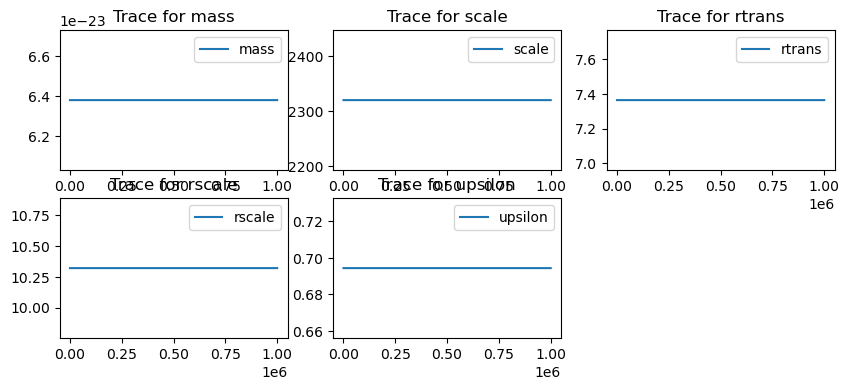

In [15]:
# Plot the traces for mu and sigma
plt.figure(figsize=(10, 4))
plt.subplot(2, 3, 1)
plt.plot(trace_params[0], label='mass')
plt.title("Trace for mass")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(trace_params[1], label='scale')
plt.title("Trace for scale")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(trace_params[2], label='rtrans')
plt.title("Trace for rtrans")
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(trace_params[3], label='rscale')
plt.title("Trace for rscale")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(trace_params[4], label='upsilon')
plt.title("Trace for upsilon")
plt.legend()

plt.show()

In [16]:
N = 100000 #No of samples to be discarded as burn-in period
print("mass",mode(trace_params[0][N:]))
print("scale",mode(trace_params[1][N:]))
print("rtrans",mode(trace_params[2][N:]))
print("rscale",mode(trace_params[3][N:]))
print("upsilon",mode(trace_params[4][N:]))

mass 6.379178683453953e-23
scale 2319.831154248168
rtrans 7.364404572314196
rscale 10.321229042244614
upsilon 0.6943628026569659


In [17]:
N = 100000 #No of samples to be discarded as burn-in period
print("mass",np.median(trace_params[0][N:]))
print("scale",np.median(trace_params[1][N:]))
print("rtrans",np.median(trace_params[2][N:]))
print("rscale",np.median(trace_params[3][N:]))
print("upsilon",np.median(trace_params[4][N:]))

mass 6.379178683453953e-23
scale 2319.831154248168
rtrans 7.364404572314196
rscale 10.321229042244614
upsilon 0.6943628026569659


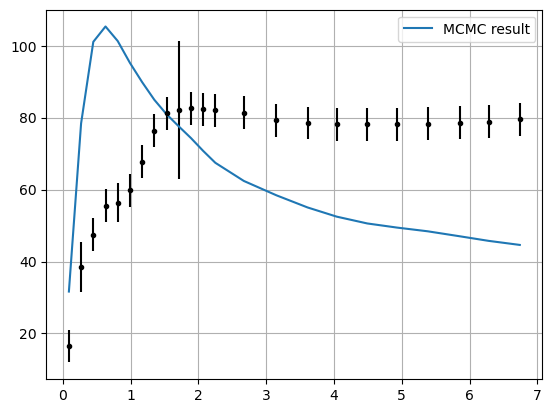

In [18]:

#params = mode(trace_params[0][N:]),mode(trace_params[1][N:]),mode(trace_params[2][N:]),mode(trace_params[3][N:]),mode(trace_params[4][N:]) #discarded first 1000 samples which were part of the burn-in period
params = np.median(trace_params[0][N:]),np.median(trace_params[1][N:]),np.median(trace_params[2][N:]),np.median(trace_params[3][N:]),np.median(trace_params[4][N:]) #discarded first 1000 samples which were part of the burn-in period
mcmc_data = model(params)

plt.figure()
#plt.scatter(x,y,label='Data')
plt.errorbar(x, y, yerr = err, c = 'k', marker='.', fmt=' ')
plt.plot(x,mcmc_data,label='MCMC result')

plt.legend()
plt.grid()
plt.savefig("UGC05721_MCMC.png")
plt.show()

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4 have no dynamic range. Please provide a `range` argument.

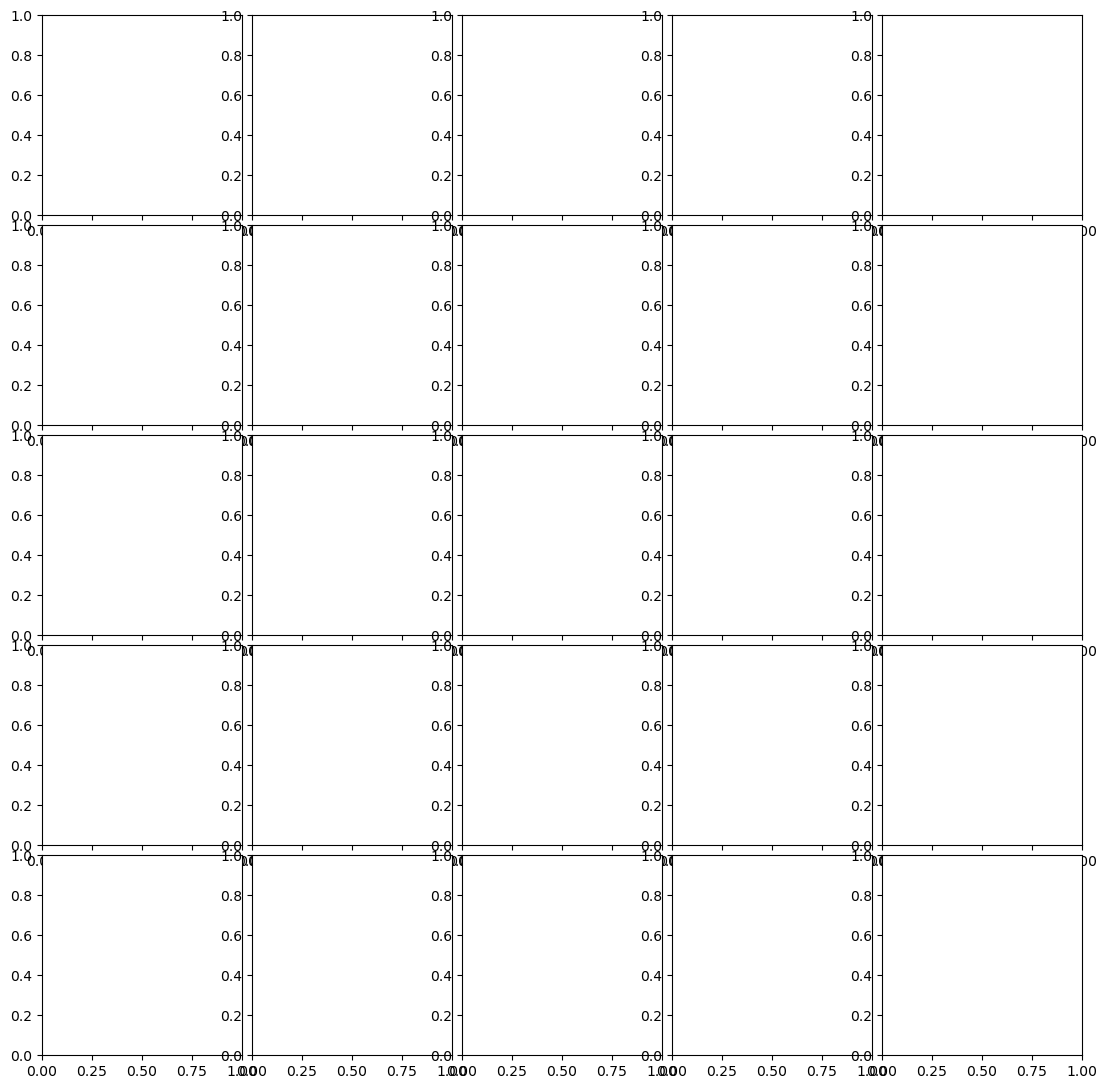

In [19]:

samples_without_burn_in = np.array([trace_params[0][N:],trace_params[1][N:],trace_params[2][N:],trace_params[3][N:],trace_params[4][N:]])

# range_values = [(min(samples_without_burn_in[0]) - 0.5, max(samples_without_burn_in[0]) + 0.5),
#                 (min(samples_without_burn_in[1]) - 0.5, max(samples_without_burn_in[1]) + 0.5)]

labels = ['mass','scale','rtrans','rscale','upsilon']
fig = corner.corner(samples_without_burn_in.T,show_titles=True,labels=labels,plot_datapoints=True, smooth = 3)